## This notebook does PCA dimensionality reduction on the data set to see if it has any affect on results. KNN showed modest improvement, that was all.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, make_scorer, log_loss
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.decomposition import PCA
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [19]:
# get the normalized data set with additional features
df = pd.read_csv('../data/processed/series_data_norm-dd-nd-082919.csv', index_col='date')
X = df.drop(['RECESSION'], axis=1)
y = df['RECESSION']

In [20]:
# pca - keep 98% of variance
pca = PCA(n_components=0.98, svd_solver='full')
principal_components = pca.fit_transform(X)
principal_df = pd.DataFrame(data = principal_components, index = X.index)
print(principal_df.shape)
X = principal_df

(546, 277)


In [22]:
mid1_2 = '1971-05-01'
mid2_3 = '1977-08-01'
mid3_4 = '1980-11-01'
mid4_5 = '1986-09-01'
mid5_6 = '1996-03-01'
mid6_7 = '2004-11-01'

X_train = X.loc[:mid6_7]
y_train = y.loc[:mid6_7]
X_test = X.loc[mid6_7:]
y_test = y.loc[mid6_7:]

# split for CV
X1_train = X.loc[mid1_2:mid6_7]
y1_train = y.loc[mid1_2:mid6_7]
X1_test = X.loc[:mid1_2].iloc[:-1]
y1_test = y.loc[:mid1_2].iloc[:-1]

X2_train = X.loc[:mid1_2] + X.loc[mid2_3:mid6_7]
y2_train = y.loc[:mid1_2] + y.loc[mid2_3:mid6_7]
X2_test = X.loc[mid1_2:mid2_3].iloc[1:-1]
y2_test = y.loc[mid1_2:mid2_3].iloc[1:-1]

X3_train = X.loc[:mid2_3] + X.loc[mid3_4:mid6_7]
y3_train = y.loc[:mid2_3] + y.loc[mid3_4:mid6_7]
X3_test = X.loc[mid2_3:mid3_4].iloc[1:-1]
y3_test = y.loc[mid2_3:mid3_4].iloc[1:-1]

X4_train = X.loc[:mid3_4] + X.loc[mid4_5:mid6_7]
y4_train = y.loc[:mid3_4] + y.loc[mid4_5:mid6_7]
X4_test = X.loc[mid3_4:mid4_5].iloc[1:-1]
y4_test = y.loc[mid3_4:mid4_5].iloc[1:-1]

X5_train = X.loc[:mid4_5] + X.loc[mid5_6:mid6_7]
y5_train = y.loc[:mid4_5] + y.loc[mid5_6:mid6_7]
X5_test = X.loc[mid4_5:mid5_6].iloc[1:-1]
y5_test = y.loc[mid4_5:mid5_6].iloc[1:-1]

X6_train = X.loc[:mid5_6]
y6_train = y.loc[:mid5_6]
X6_test = X.loc[mid5_6:mid6_7].iloc[1:-1]
y6_test = y.loc[mid5_6:mid6_7].iloc[1:-1]

X1_train_i = pd.Index([X.index.get_loc(i) for i in X1_train.index])
X1_test_i = pd.Index([X.index.get_loc(i) for i in X1_test.index])

X2_train_i = pd.Index([X.index.get_loc(i) for i in X2_train.index])
X2_test_i = pd.Index([X.index.get_loc(i) for i in X2_test.index])

X3_train_i = pd.Index([X.index.get_loc(i) for i in X3_train.index])
X3_test_i = pd.Index([X.index.get_loc(i) for i in X3_test.index])

X4_train_i = pd.Index([X.index.get_loc(i) for i in X4_train.index])
X4_test_i = pd.Index([X.index.get_loc(i) for i in X4_test.index])

X5_train_i = pd.Index([X.index.get_loc(i) for i in X5_train.index])
X5_test_i = pd.Index([X.index.get_loc(i) for i in X5_test.index])

X6_train_i = pd.Index([X.index.get_loc(i) for i in X6_train.index])
X6_test_i = pd.Index([X.index.get_loc(i) for i in X6_test.index])

mankf = [[X1_train_i, X1_test_i], [X2_train_i, X2_test_i], [X3_train_i, X3_test_i], [X4_train_i, X4_test_i],\
         [X5_train_i, X5_test_i], [X6_train_i, X6_test_i]]

In [4]:
# custom scoring function v2
def my_score(y_test, y_pred):
    y_test2 = list(y_test)
    y_pred2 = list(y_pred)
    max_y_index = len(y_test2)
    first_1 = True
    for i, val in enumerate(y_test2):
        if val == 0 and (1 not in y_test2[i:min(i+7, max_y_index)]) and y_pred2[i] == 1:
            return 0
        elif val == 0:
            first_1 = True
        elif first_1 == True and val == 1:
            if 1 not in y_pred[max(0,i-6):min(i+6,max_y_index)]:
                return 0
            else:
                first_1 = False
    return accuracy_score(y_test2, y_pred2)
custom_score = make_scorer(my_score)

In [23]:
lrc = LogisticRegression(random_state=42)
p_grid = [
    {'penalty':['l2', 'none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight': ['balanced', None],
     'C': [0.1, 1.0, 10.0]
     }
]
clf = GridSearchCV(estimator=lrc, cv=mankf, param_grid=p_grid, scoring='neg_log_loss')
clf.fit(X,y)
print(clf.best_params_)
gsdf = pd.DataFrame(clf.cv_results_)
gsdf[gsdf.rank_test_score < 20]

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252014,0.075014,0.007167,0.008631,0.1,balanced,l2,newton-cg,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-0.809891,-0.392963,-1.213611,-1.636911,-0.496932,-0.446756,-0.719189,0.444826,1
2,0.163568,0.019771,0.007667,0.011776,0.1,balanced,l2,sag,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-0.245215,-0.581398,-2.090085,-0.324062,-2.049548,-3.391775,-1.809130,1.172784,17
3,0.256352,0.021574,0.001494,0.000500,0.1,balanced,l2,saga,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-0.263607,-0.557575,-1.863419,-0.311237,-1.728683,-2.823746,-1.545176,0.956356,5
7,0.225037,0.027615,0.001159,0.000376,0.1,balanced,none,saga,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-0.263591,-0.557595,-1.863505,-0.311232,-1.728792,-2.823970,-1.545274,0.956441,8
8,0.227700,0.025716,0.001499,0.000500,0.1,None,l2,newton-cg,"{'C': 0.1, 'class_weight': None, 'penalty': 'l...",-1.069745,-0.478267,-0.936986,-1.742352,-0.570379,-0.452392,-0.759738,0.445292,2
11,0.271849,0.040587,0.001991,0.000581,0.1,None,l2,saga,"{'C': 0.1, 'class_weight': None, 'penalty': 'l...",-0.257681,-0.521441,-1.588532,-0.318293,-1.834282,-3.212257,-1.645240,1.102515,11
15,0.238362,0.031709,0.004164,0.004876,0.1,None,none,saga,"{'C': 0.1, 'class_weight': None, 'penalty': 'n...",-0.257667,-0.521450,-1.588629,-0.318285,-1.834400,-3.212491,-1.645342,1.102607,14
16,0.173231,0.040194,0.002499,0.000764,1,balanced,l2,newton-cg,"{'C': 1.0, 'class_weight': 'balanced', 'penalt...",-0.886415,-0.479354,-1.718837,-1.888953,-0.365352,-1.761673,-1.123741,0.676980,4
18,0.190729,0.028157,0.007490,0.012307,1,balanced,l2,sag,"{'C': 1.0, 'class_weight': 'balanced', 'penalt...",-0.245186,-0.581455,-2.090303,-0.324063,-2.049860,-3.392350,-1.809396,1.173000,18
19,0.266677,0.030183,0.001500,0.000504,1,balanced,l2,saga,"{'C': 1.0, 'class_weight': 'balanced', 'penalt...",-0.263592,-0.557593,-1.863497,-0.311233,-1.728781,-2.823947,-1.545264,0.956432,6


In [15]:
# tuned to custom score

lr_clf = LogisticRegression(random_state=42, solver='newton-cg', multi_class='ovr', C=10.0, class_weight='balanced', penalty='l2')
lr_clf.fit(X_train, y_train)
log_loss(y_test, lr_clf.predict_proba(X_test))

0.170022693736929

In [24]:
# tuned to log loss

lr_clf = LogisticRegression(random_state=42, solver='newton-cg', multi_class='ovr', C=0.1, class_weight='balanced', penalty='l2')
lr_clf.fit(X_train, y_train)
log_loss(y_test, lr_clf.predict_proba(X_test))

0.1196926557587216

In [11]:
j=1969
xt=[]
xtl=[]
for i,yr in enumerate(list(pd.to_datetime(y.index).year)):
    if yr==j:
        xt.append(i)
        xtl.append(yr)
        j += 2

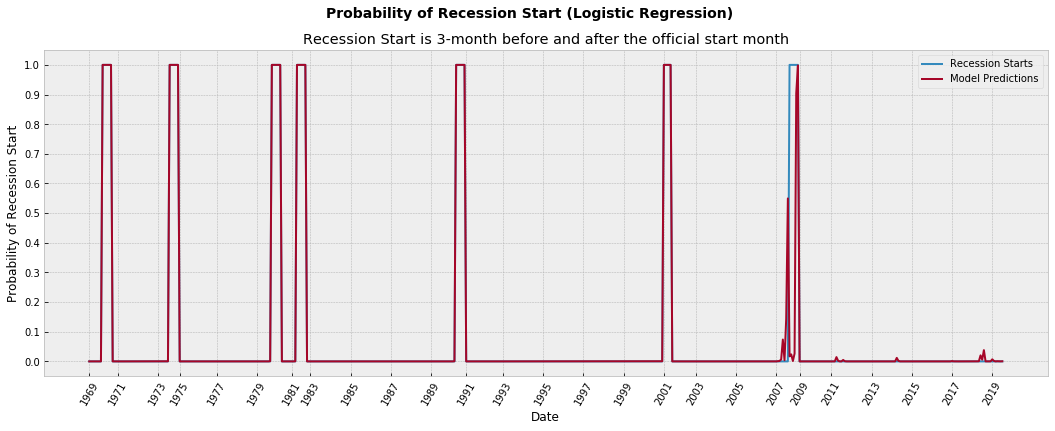

In [25]:
y_pred = lr_clf.predict_proba(X)[:,1]
mpl.style.use('bmh')
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Logistic Regression)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [47]:
rfc = RandomForestClassifier()
p_grid = [
    {'n_estimators': [10, 100, 1000],
     'max_depth': [4, 2, None],
     'min_samples_split': [2, 4, 10],
     'criterion': ['gini', 'entropy'],
     'min_samples_leaf':[1, 2],
     'max_features':['sqrt', None],
     'class_weight':['balanced', None]
     }
]
clf = GridSearchCV(estimator=rfc, cv=mankf, param_grid=p_grid, scoring=custom_score)
clf.fit(X,y)
print(clf.best_params_)
gsrfdf = pd.DataFrame(clf.cv_results_)
gsrfdf[gsrfdf.rank_test_score <= 20]

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
21,0.288501,0.067585,0.004167,0.003575,balanced,gini,4,None,1,4,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.000000,0.918033,0.000000,0.964286,0.935185,0.000000,0.556728,0.460771,17
24,0.202551,0.016193,0.001998,0.000002,balanced,gini,4,None,1,10,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.000000,0.934426,0.000000,0.946429,0.935185,0.000000,0.556728,0.460604,17
25,1.987689,0.132870,0.013826,0.012202,balanced,gini,4,None,1,10,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.000000,0.934426,0.914286,0.946429,0.935185,0.000000,0.641161,0.433832,10
26,20.174536,1.543746,0.145587,0.023569,balanced,gini,4,None,1,10,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.761905,0.934426,0.885714,0.964286,0.925926,0.000000,0.680739,0.404276,6
28,2.262368,0.379866,0.014822,0.012329,balanced,gini,4,None,2,2,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.761905,0.934426,0.885714,0.964286,0.935185,0.000000,0.683377,0.405894,5
34,2.007511,0.167532,0.022152,0.019197,balanced,gini,4,None,2,10,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.000000,0.934426,0.914286,0.964286,0.916667,0.000000,0.638522,0.432268,11
35,20.324621,1.582486,0.154412,0.040984,balanced,gini,4,None,2,10,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.000000,0.934426,0.885714,0.964286,0.925926,0.000000,0.638522,0.432398,11
63,0.185558,0.020792,0.002001,0.000573,balanced,gini,2,None,2,2,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.809524,0.967213,0.857143,0.946429,0.925926,0.959184,0.931398,0.042192,1
90,0.219873,0.021554,0.002162,0.000380,balanced,gini,None,None,1,2,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.809524,0.918033,0.857143,0.964286,0.935185,0.000000,0.680739,0.403744,6
94,2.178740,0.202919,0.025487,0.026068,balanced,gini,None,None,1,4,...,"{'class_weight': 'balanced', 'criterion': 'gin...",0.000000,0.934426,0.857143,0.964286,0.935185,0.000000,0.638522,0.432759,11


In [50]:
#tuned on custom score
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=2, min_samples_split=2, random_state=42, class_weight='balanced',\
                               criterion='gini', max_features=None, min_samples_leaf=2)
rf_clf.fit(X_train, y_train)
log_loss(y_test, rf_clf.predict_proba(X_test))

0.42365270105985153

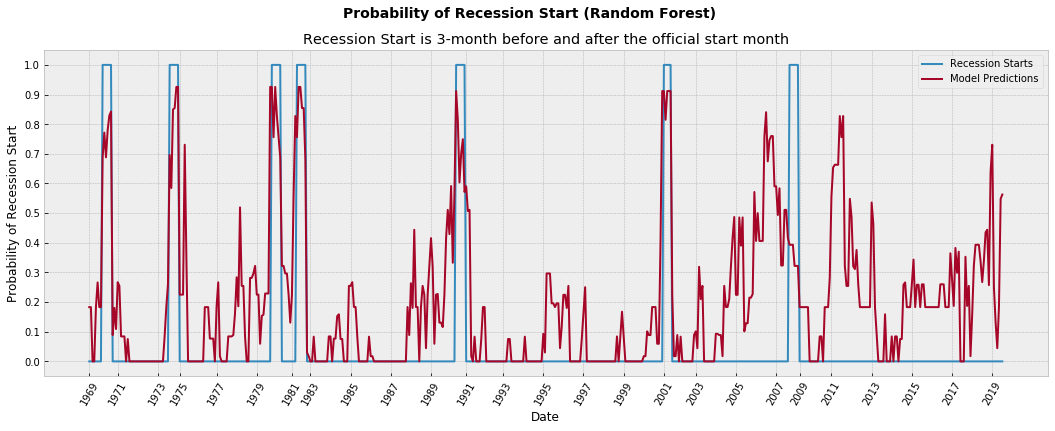

In [51]:
y_pred = rf_clf.predict_proba(X)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Random Forest)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [29]:
svc = SVC(random_state=42, probability=True)
p_grid = [
    {'kernel': ['poly', 'sigmoid', 'rbf'],
     'C': [0.1, 1.0, 10.0],
     'gamma':['auto', 'scale'],
     'shrinking': [True, False],
     'class_weight':['balanced', None],
     'decision_function_shape':['ovo', 'ovr']
     }
]
clf = GridSearchCV(estimator=svc, cv=mankf, param_grid=p_grid, scoring='neg_log_loss')
clf.fit(X,y)
print(clf.best_params_)
gssvc_df = pd.DataFrame(clf.cv_results_)
gssvc_df[gssvc_df.rank_test_score < 20]

{'C': 0.1, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_decision_function_shape,param_gamma,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
10,0.296996,0.076421,0.025316,0.020016,0.1,balanced,ovo,scale,rbf,True,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.662522,-0.187956,-0.276312,-0.402022,-0.221767,-0.175172,-0.260370,0.122861,13
11,0.310154,0.046217,0.006665,0.002131,0.1,balanced,ovo,scale,rbf,False,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.662522,-0.187956,-0.276312,-0.402022,-0.221767,-0.175172,-0.260370,0.122861,13
22,0.295163,0.068705,0.012160,0.011195,0.1,balanced,ovr,scale,rbf,True,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.662522,-0.187956,-0.276312,-0.402022,-0.221767,-0.175172,-0.260370,0.122861,13
23,0.289996,0.057320,0.017329,0.017150,0.1,balanced,ovr,scale,rbf,False,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.662522,-0.187956,-0.276312,-0.402022,-0.221767,-0.175172,-0.260370,0.122861,13
30,0.203718,0.046612,0.004999,0.000997,0.1,None,ovo,scale,poly,True,"{'C': 0.1, 'class_weight': None, 'decision_fun...",-0.273449,-0.119109,-0.356115,-0.351371,-0.223692,-0.197268,-0.233878,0.077476,9
31,0.199552,0.048926,0.015491,0.015630,0.1,None,ovo,scale,poly,False,"{'C': 0.1, 'class_weight': None, 'decision_fun...",-0.273449,-0.119109,-0.356115,-0.351371,-0.223692,-0.197268,-0.233878,0.077476,11
34,0.167235,0.047406,0.004333,0.001246,0.1,None,ovo,scale,rbf,True,"{'C': 0.1, 'class_weight': None, 'decision_fun...",-0.339932,-0.145036,-0.465330,-0.340479,-0.178380,-0.166986,-0.229469,0.102640,1
35,0.140255,0.037814,0.019988,0.017339,0.1,None,ovo,scale,rbf,False,"{'C': 0.1, 'class_weight': None, 'decision_fun...",-0.339932,-0.145036,-0.465330,-0.340479,-0.178380,-0.166986,-0.229469,0.102640,1
42,0.203050,0.036235,0.019489,0.020194,0.1,None,ovr,scale,poly,True,"{'C': 0.1, 'class_weight': None, 'decision_fun...",-0.273449,-0.119109,-0.356115,-0.351371,-0.223692,-0.197268,-0.233878,0.077476,9
43,0.210210,0.055045,0.016325,0.017171,0.1,None,ovr,scale,poly,False,"{'C': 0.1, 'class_weight': None, 'decision_fun...",-0.273449,-0.119109,-0.356115,-0.351371,-0.223692,-0.197268,-0.233878,0.077476,11


In [27]:
# tuned by custom score
svc_clf = SVC(random_state=42, C=0.1, class_weight='balanced', decision_function_shape='ovo', gamma='scale',\
             kernel='rbf', shrinking=True, probability=True)
svc_clf.fit(X_train, y_train)
log_loss(y_test, svc_clf.predict_proba(X_test))

0.10716842866330907

In [30]:
# tuned by log loss
svc_clf = SVC(random_state=42, C=0.1, class_weight=None, decision_function_shape='ovo', gamma='scale',\
             kernel='rbf', shrinking=True, probability=True)
svc_clf.fit(X_train, y_train)
log_loss(y_test, svc_clf.predict_proba(X_test))

0.1230156032991738

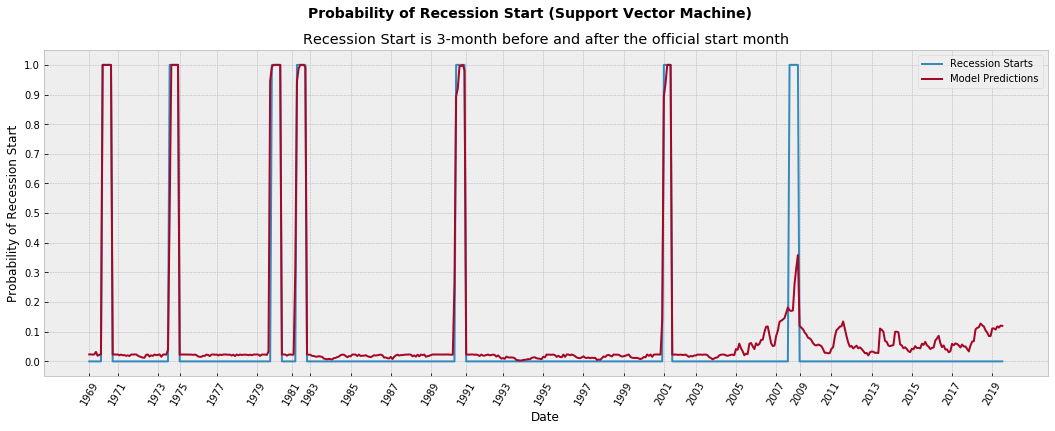

In [31]:
y_pred = svc_clf.predict_proba(X)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Support Vector Machine)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [35]:
knc = KNeighborsClassifier()
p_grid = [
    {'n_neighbors': [1, 3, 5, 10, 20],
     'weights': ['uniform', 'distance'],
     'algorithm':['ball_tree', 'kd_tree', 'brute'],
     'leaf_size': [30, 50],
     'p':[1, 2],
      }
]
clf = GridSearchCV(estimator=knc, cv=mankf, param_grid=p_grid, scoring='neg_log_loss')
clf.fit(X,y)
print(clf.best_params_)
gskn_df = pd.DataFrame(clf.cv_results_)
gskn_df[gskn_df.rank_test_score < 20]

{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
16,0.003164,0.000374,0.018824,0.016659,ball_tree,30,20,1,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",-5.364515,-0.236866,-2.289921,-0.284637,-1.343508,-0.448881,-1.087809,1.217761,19
17,0.008990,0.011643,0.012994,0.011436,ball_tree,30,20,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",-5.366441,-0.235802,-2.289423,-0.284336,-1.343672,-0.448841,-1.087691,1.218255,13
18,0.008830,0.012593,0.013158,0.013924,ball_tree,30,20,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",-0.574278,-0.251241,-0.427180,-0.234876,-1.042387,-0.788948,-0.647453,0.323756,7
19,0.003164,0.000373,0.013993,0.010826,ball_tree,30,20,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",-0.574958,-0.249469,-0.429935,-0.234284,-1.042991,-0.787533,-0.647178,0.324088,1
36,0.002499,0.000499,0.017157,0.013926,ball_tree,50,20,1,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",-5.364515,-0.236866,-2.289921,-0.284637,-1.343508,-0.448881,-1.087809,1.217761,19
37,0.003163,0.000373,0.015327,0.013795,ball_tree,50,20,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",-5.366441,-0.235802,-2.289423,-0.284336,-1.343672,-0.448841,-1.087691,1.218255,13
38,0.002831,0.000372,0.018487,0.015701,ball_tree,50,20,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",-0.574278,-0.251241,-0.427180,-0.234876,-1.042387,-0.788948,-0.647453,0.323756,7
39,0.002998,0.000007,0.024153,0.017905,ball_tree,50,20,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",-0.574958,-0.249469,-0.429935,-0.234284,-1.042991,-0.787533,-0.647178,0.324088,1
56,0.020656,0.016356,0.015490,0.011232,kd_tree,30,20,1,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",-5.364515,-0.236866,-2.289921,-0.284637,-1.343508,-0.448881,-1.087809,1.217761,19
57,0.003665,0.000471,0.020486,0.017923,kd_tree,30,20,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",-5.366441,-0.235802,-2.289423,-0.284336,-1.343672,-0.448841,-1.087691,1.218255,13


In [33]:
# tuned by custom score
kn_clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, n_neighbors=3, p=2, weights='uniform')
kn_clf.fit(X_train, y_train)
print(log_loss(y_test, kn_clf.predict_proba(X_test)))

0.6656844401395632


In [36]:
# tuned by log loss
kn_clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, n_neighbors=20, p=2, weights='distance')
kn_clf.fit(X_train, y_train)
print(log_loss(y_test, kn_clf.predict_proba(X_test)))

0.1088183947823538


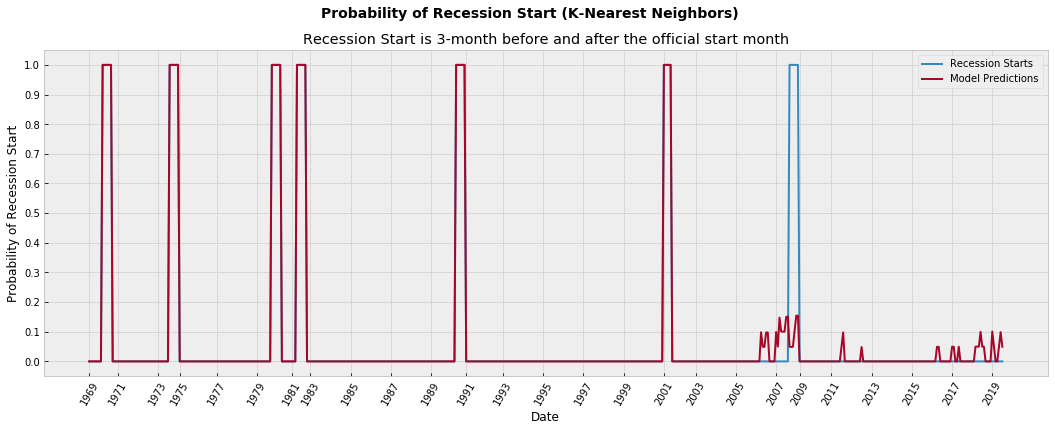

In [37]:
y_pred = kn_clf.predict_proba(X)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (K-Nearest Neighbors)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [38]:
n_cols = X.shape[1]
input_shape = (n_cols,)
target = to_categorical(y_train)
predictors = X_train.values

In [44]:
# Specify the model
model = Sequential()
model.add(Dense(300, activation='relu', input_shape = input_shape))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=6, restore_best_weights=True)

# Fit the model
model.fit(predictors, target, epochs=30, validation_split=0.3,callbacks=[early_stopping_monitor])

Train on 269 samples, validate on 116 samples
Epoch 1/30
269/269 [==============================] - 4s 14ms/step - loss: 2.4184 - val_loss: 0.6947
Epoch 2/30
269/269 [==============================] - 2s 7ms/step - loss: 1.4851 - val_loss: 0.6947
Epoch 3/30
269/269 [==============================] - 2s 7ms/step - loss: 1.6178 - val_loss: 0.6947
Epoch 4/30
269/269 [==============================] - 2s 7ms/step - loss: 1.7376 - val_loss: 0.6947
Epoch 5/30
269/269 [==============================] - 2s 7ms/step - loss: 1.7376 - val_loss: 0.6947
Epoch 6/30
269/269 [==============================] - 2s 7ms/step - loss: 1.7376 - val_loss: 0.6947
Epoch 7/30
269/269 [==============================] - 2s 7ms/step - loss: 1.7376 - val_loss: 0.6947


In [45]:
log_loss(y_test, model.predict(X_test))

1.2792139406557437

In [75]:
j=1969
xt=[]
xtl=[]
for i,yr in enumerate(list(pd.to_datetime(y.index).year)):
    if yr==j:
        xt.append(i)
        xtl.append(yr)
        j += 2

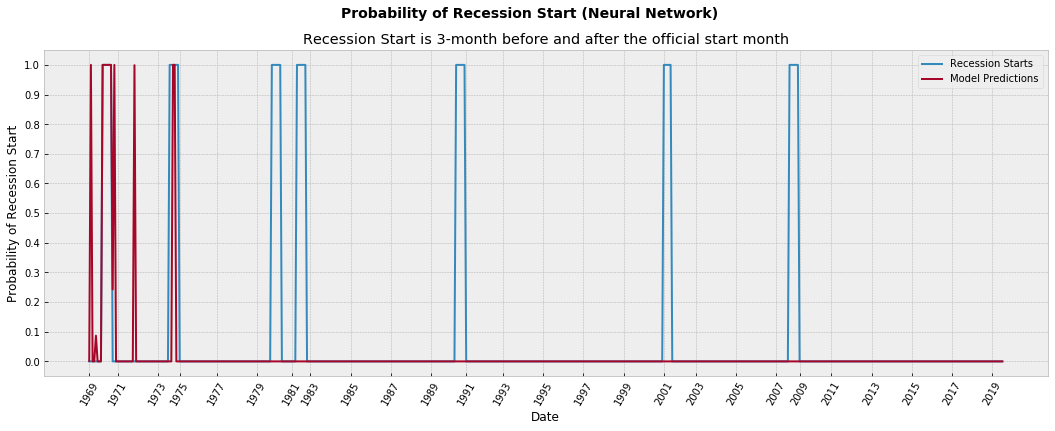

In [46]:
y_pred = model.predict(X.values)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Neural Network)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()